In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Define the 2D Rastrigin function
def rastrigin(x):
    A = 10
    return A * x.shape[1] + torch.sum(x**2 - A * torch.cos(2 * np.pi * x), dim=1)

def rastrigin_np(x, y):
    A = 10
    return A * 2 + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y))

# 2. Generate training data
N = 5
x_2d = torch.FloatTensor(N, 2).uniform_(-5.12, 5.12).to(device)
y = rastrigin(x_2d).cpu().numpy()



# 4. Set up diffusion parameters
n_features = 2
n_conditions = 4
n_timesteps = 1000


# 3. Bin f(x) values into 3 classes: low, mid, high
bins = KBinsDiscretizer(n_bins=n_conditions, encode='ordinal', strategy='quantile')
bins.fit(y.reshape(-1, 1))  # 🎯 fit은 한 번만! 기준 고정
y_bins = bins.transform(y.reshape(-1, 1)).astype(int).flatten()
y_bins = torch.tensor(y_bins, dtype=torch.long).to(device)




def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(n_timesteps).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def q_sample(x_0, t, noise):
    sqrt_alphas_cumprod_t = alphas_cumprod[t].sqrt().unsqueeze(1)
    sqrt_one_minus_alphas_cumprod_t = (1 - alphas_cumprod[t]).sqrt().unsqueeze(1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

# 5. Define conditional embedding and denoiser
class ConditionEmbedding(nn.Module):
    def __init__(self, n_conditions, emb_dim):
        super().__init__()
        self.embedding = nn.Embedding(n_conditions, emb_dim)

    def forward(self, c):
        return self.embedding(c)

class Denoiser(nn.Module):
    def __init__(self, n_features, cond_dim):
        super().__init__()
        self.fc1 = nn.Linear(n_features + cond_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_features)

    def forward(self, x, c_emb):
        h = torch.cat([x, c_emb], dim=-1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

# 6. Train step
def train_step(model, cond_emb, x_0, c, optimizer):
    model.train()
    t = torch.randint(0, n_timesteps, (x_0.shape[0],), device=device)
    noise = torch.randn_like(x_0)
    x_t = q_sample(x_0, t, noise)

    c_emb = cond_emb(c)
    noise_pred = model(x_t, c_emb)

    loss = F.mse_loss(noise_pred, noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# 7. Sampling function
@torch.no_grad()
def sample(model, cond_emb, c, n_samples=1):
    model.eval()
    x = torch.randn((n_samples, n_features), device=device)
    c = c.repeat(n_samples)
    c_emb = cond_emb(c)

    for t in reversed(range(n_timesteps)):
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_hat_t = alphas_cumprod[t]

        noise_pred = model(x, c_emb)
        x = (1 / alpha_t.sqrt()) * (x - ((1 - alpha_t) / (1 - alpha_hat_t).sqrt()) * noise_pred)

        if t > 0:
            noise = torch.randn_like(x)
            x += beta_t.sqrt() * noise

    return x.cpu()

# 8. Initialize and train model
model = Denoiser(n_features=2, cond_dim=16).to(device)
cond_emb = ConditionEmbedding(n_conditions=n_conditions, emb_dim=16).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(cond_emb.parameters()), lr=1e-3)

losses = []
for epoch in range(500):
    loss = train_step(model, cond_emb, x_2d, y_bins, optimizer)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")
    losses.append(loss)




Epoch 0, Loss: 1.4796
Epoch 50, Loss: 0.7834
Epoch 100, Loss: 0.6714
Epoch 150, Loss: 0.4789
Epoch 200, Loss: 0.3434
Epoch 250, Loss: 0.1622
Epoch 300, Loss: 0.3138
Epoch 350, Loss: 0.2689
Epoch 400, Loss: 0.3802
Epoch 450, Loss: 0.1069


In [146]:
x_2d

tensor([[ 0.0220, -1.5084],
        [-4.4984, -4.2563],
        [-2.2816, -2.9426],
        [ 0.3570, -0.9460],
        [ 0.7434, -2.2096]])

In [147]:
# 9. Sample from the model under "low" condition
low_condition = torch.tensor([0], device=device)  # class 0: lowest Rastrigin values
generated_samples = sample(model, cond_emb, low_condition, n_samples=1000)

# Return the generated samples and training loss for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_samples = pd.DataFrame(generated_samples.numpy(), columns=["x1", "x2"])
df_samples["f(x)"] = rastrigin(generated_samples).numpy()


/var/folders/c9/14_8p05x241fyxw1d_hqydvr0000gq/T/ipykernel_43962/1911919946.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", n_conditions)


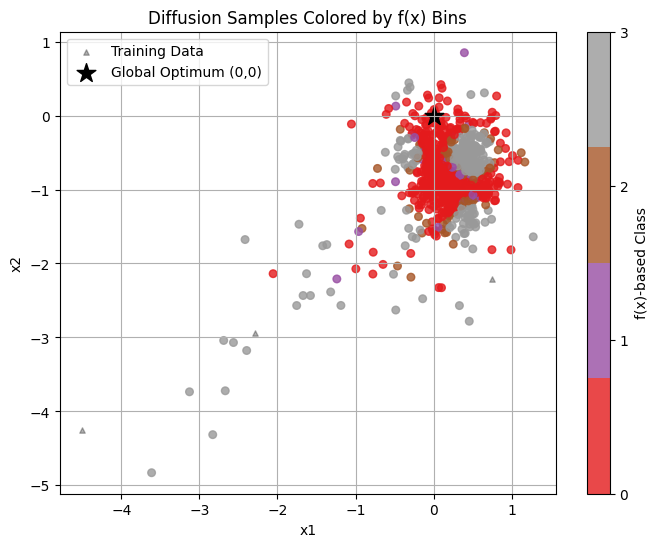

In [148]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the Rastrigin function
# 👉 클리핑: [-5.12, 5.12] 범위로 제한
# df_samples["x1"] = np.clip(df_samples["x1"], -5.12, 5.12)
# df_samples["x2"] = np.clip(df_samples["x2"], -5.12, 5.12)

# 조건을 만족하는 행만 남긴다 (x1, x2 모두 범위 안에 있을 때)
df_samples = df_samples[
    (df_samples["x1"] >= -5.12) & (df_samples["x1"] <= 5.12) &
    (df_samples["x2"] >= -5.12) & (df_samples["x2"] <= 5.12)
].reset_index(drop=True)

# 👉 Rastrigin 재계산
def rastrigin_np(x, y):
    A = 10
    return A * 2 + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y))

df_samples["f(x)"] = rastrigin_np(df_samples["x1"], df_samples["x2"])
fx_values = df_samples["f(x)"].values.reshape(-1, 1)

# bins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
# class_labels = bins.fit_transform(fx_values).astype(int).flatten()
class_labels = bins.transform(fx_values).astype(int).flatten()

df_samples["class"] = class_labels


plt.figure(figsize=(8, 6))
cmap = plt.cm.get_cmap("Set1", n_conditions)

# 🎨 1. 학습 데이터 (x_2d) 표시
plt.scatter(
    x_2d[:, 0].cpu(), x_2d[:, 1].cpu(),
    color='black', s=15, alpha=0.3,
    label='Training Data', marker='^'
)


scatter = plt.scatter(
    df_samples["x1"],
    df_samples["x2"],
    c=df_samples["class"],
    cmap=cmap,
    s=30, alpha=0.8
)

plt.scatter(0, 0, c='black', marker='*', s=200, label='Global Optimum (0,0)')

cbar = plt.colorbar(scatter, ticks=[0, 1, 2,3])
cbar.set_label("f(x)-based Class")
cbar.ax.set_yticklabels(['0', '1', '2', '3'])

plt.title("Diffusion Samples Colored by f(x) Bins")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()


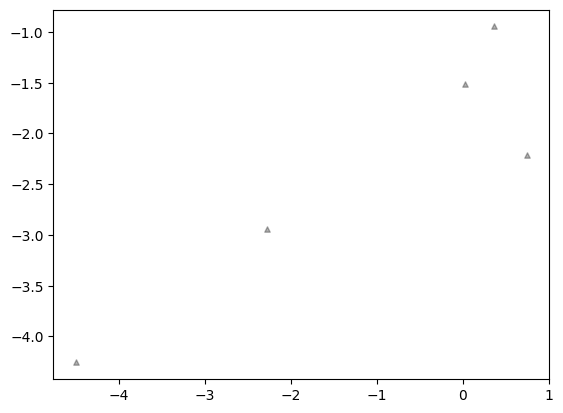

In [149]:
plt.scatter(
    x_2d[:, 0].cpu(), x_2d[:, 1].cpu(),
    color='black', s=15, alpha=0.3,
    label='Training Data', marker='^'
)
plt.show()

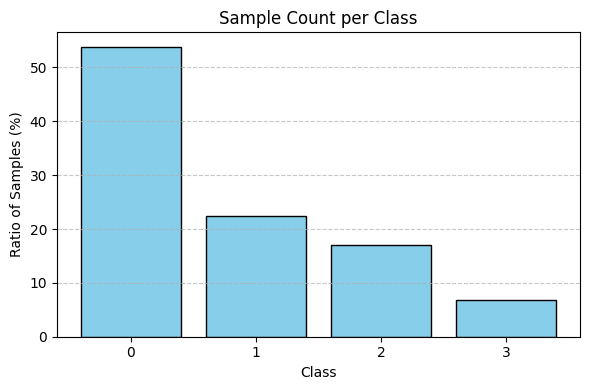

In [144]:
# Assume df_samples is already available in memory and contains a "class" column
# Count occurrences of each class
class_counts = df_samples["class"].value_counts().sort_index()
class_ratios = class_counts / class_counts.sum()

# Format the result as a DataFrame for display
class_distribution = pd.DataFrame({
    "Class": class_counts.index,
    "Count": class_counts.values,
    "Ratio": class_ratios.values
})


# Create bar chart from class_distribution
plt.figure(figsize=(6, 4))
plt.bar(class_distribution["Class"].astype(str), class_distribution["Ratio"] * 100, color='skyblue', edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Ratio of Samples (%)")
plt.title("Sample Count per Class")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



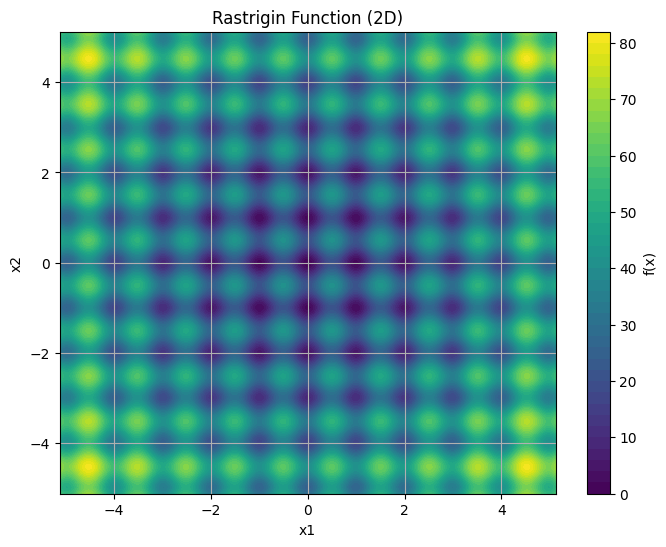

In [85]:


# Define Rastrigin function for plotting
def rastrigin_np(x, y):
    A = 10
    return A * 2 + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y))


# Create a grid of points
x_vals = np.linspace(-5.12, 5.12, 400)
y_vals = np.linspace(-5.12, 5.12, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rastrigin_np(X, Y)

# Plot the Rastrigin function
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='f(x)')
plt.title("Rastrigin Function (2D)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()
